<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/7_arima_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load DataFrames called `logins`, `paper` and `pollution` from chapter 7 of Makridakis.

In [1]:
! pip install --upgrade statsmodels

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

!curl https://vcu-scma-440.s3.amazonaws.com/data/pollution.csv > pollution.csv
!curl https://vcu-scma-440.s3.amazonaws.com/data/logins.csv > logins.csv
!curl https://vcu-scma-440.s3.amazonaws.com/data/paper.csv > paper.csv

paper = pd.read_csv('paper.csv', parse_dates=['date']).set_index('date')
logins = pd.read_csv('logins.csv')
pollution = pd.read_csv('pollution.csv', parse_dates=['date']).set_index('date')


Requirement already up-to-date: statsmodels in /opt/miniconda3/lib/python3.7/site-packages (0.12.2)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2527  100  2527    0     0  26882      0 --:--:-- --:--:-- --:--:-- 26882
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   380  100   380    0     0   4130      0 --:--:-- --:--:-- --:--:--  4130
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2259  100  2259    0     0  28594      0 --:--:-- --:--:-- --:--:-- 28594


# Exploring the Data

First, let's take a look at our data sets. We'll first look at the `logins` data set. 

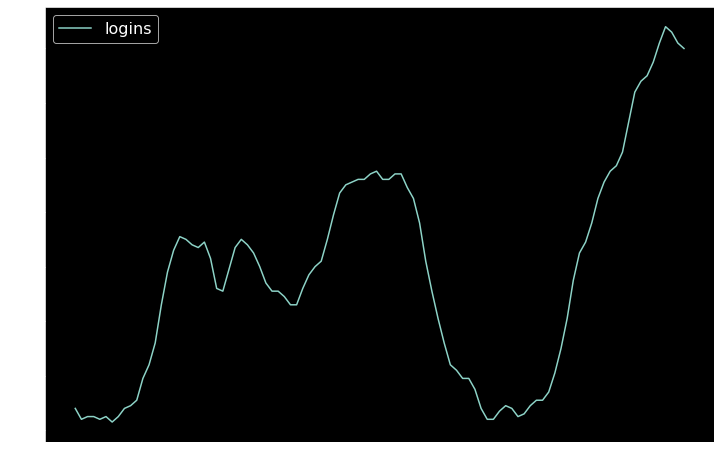

In [2]:
display(logins.plot())

It's fairly clear that this data is non-stationary, so let's start by differencing, using the `.diff()` function:

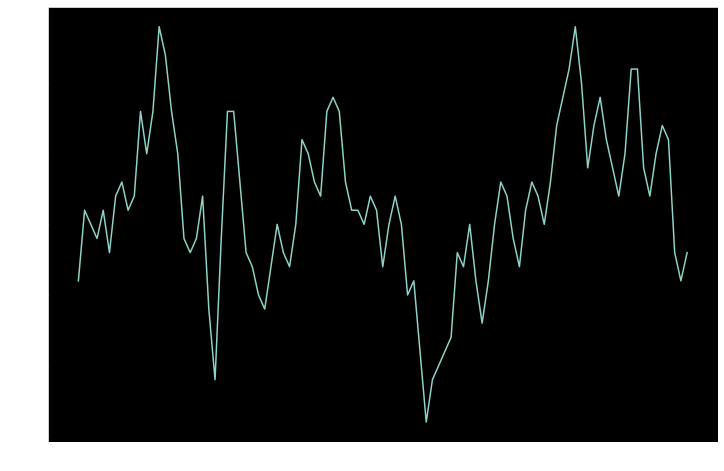

In [3]:
logins['diff'] = logins['logins'].diff()
logins['diff'].plot()

logins = logins.dropna()

## Examining Autocorrelations
Next, let's analyze the differenced series above autocorrelations. We'll do so by:

* Computing the ACF and PACF
* Portmandeau Tests

To plot the ACF and PACF, we can use the functions `plot_acf` and `plot_pacf` from `statsmodels.graphics.tsaplots`. To import, we call:

```python
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
```

To plot the ACF and PACF, we simply pass in the column that we're interested in, e.g.:

```python
my_figure = plot_acf(my_data['my_column'], zero=False)
```

We add in the `zero=False` argument to prevent the ACF from plotting the self correlation term which is always 1

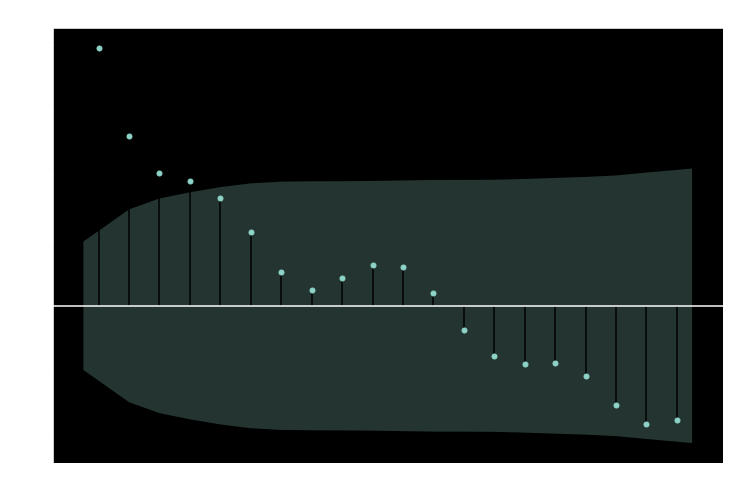

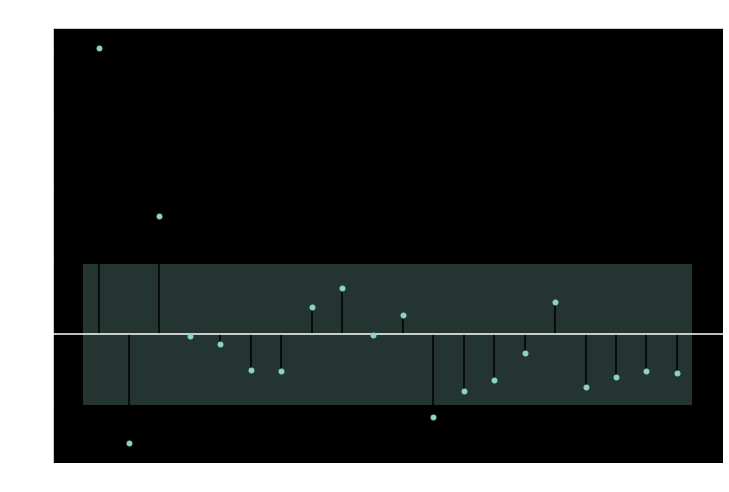

In [4]:
my_acf = plot_acf(logins['diff'], zero=False)
my_pacf = plot_pacf(logins['diff'], zero=False)

Here, we observe a strong autocorrelation at lags 1, 2, and 3, indicating that an **AR(3)** model may be appropriate. 

To fit an **AR(3)** model to our data, we'll use the `ARIMA` function from `statsmodels.tsa.arima_model`, which can be imported with:

```python
from statsmodels.tsa.arima.model import ARIMA
```

The `ARIMA` function takes the data as the first argument, and the order of the model in the form `(p, d, q)` as the second argument, e.g.:

```python
model = ARIMA(data['my_column'], order=(1,1,0))
results = model.fit()
print(results.summary())

```

In [25]:
model = ARIMA(logins['logins'], order=(3,1,0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 logins   No. Observations:                   99
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -248.716
Date:                Sun, 11 Apr 2021   AIC                            505.433
Time:                        17:59:29   BIC                            515.773
Sample:                             0   HQIC                           509.615
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1548      0.101     11.411      0.000       0.956       1.353
ar.L2         -0.6615      0.133     -4.990      0.000      -0.921      -0.402
ar.L3          0.3377      0.092      3.661      0.0

/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The summary above prints out quite a but of interesting information, including the Ljung-Box `Q` statistic (and corresponding p-value), the `AIC`, as well as `p-values` for each of the individual fit parameters (3 in the case of an **AR(3)** model. 

Each of the three parameters in the model are significant, so this model appears to be a good choice for the data. 

The large p-value for the Q statistic (much larger than 0.05) indicates that the residuals exhibit very little autocorrelation. We can plot the residuals with:

```python
results.resid.plot()
```

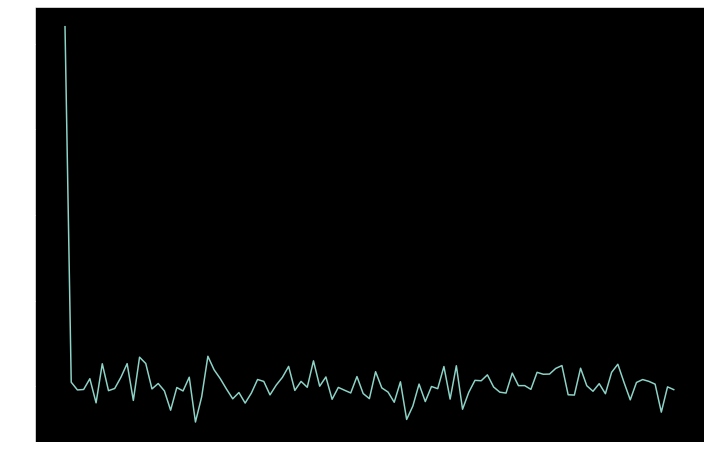

In [27]:
results.resid.plot()

Ignoring the first point which is a holdover from differencing, we see that there appears to be no pattern in the residuals. We can further explore that we've captured all of the pattern in the data by plotting the ACF and PACF for the residuals, with:

```python
plot_acf(results.resid, zero=False)
plot_pacf(results.resid, zero=False)
```

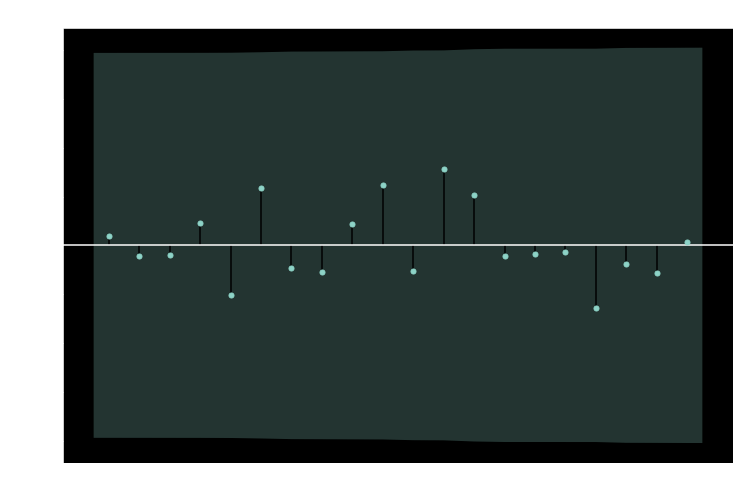

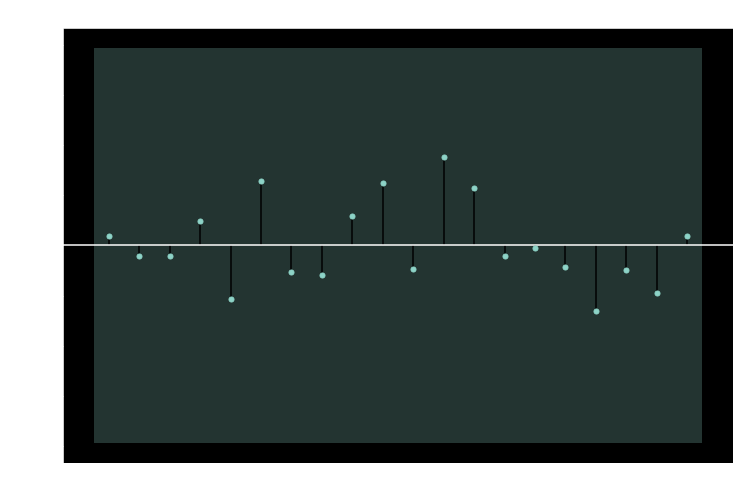

In [31]:
my_acf = plot_acf(results.resid, zero=False)
my_pacf = plot_pacf(results.resid, zero=False)

As is clear from the plot above, there is no clear autocorrelation pattern remaining in the residuals of the data. 